In [10]:
from lxml import etree
import pdb
import re
from xml.dom import minidom
import numpy as np
import pdb
from skimage.draw import polygon
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
path='./cubicasa5k/high_quality/17/F1_scaled.png'
#svg=minidom.parse(path)
fplan=cv2.imread(path)
fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
fplan.shape

(1270, 814, 3)

In [5]:

class Wall:
    def __init__(self, id, end_points, direction, width, name):
        self.id = id
        self.name = name
        self.end_points = end_points
        self.direction = direction
        self.max_width = width
        self.min_width = width

    def change_end_points(self):
        if self.direction == 'V':
            self.end_points[0][0] = np.mean(np.array(self.min_coord))
            self.end_points[1][0] = self.end_points[0][0]
        elif self.direction == 'H':
            self.end_points[0][1] = np.mean(np.array(self.min_coord))
            self.end_points[1][1] = self.end_points[0][1]

    def get_length(self, end_points):
        return calc_distance(end_points[0], end_points[1])
class PolygonWall(Wall):
    def __init__(self, e, id, shape=None):
        self.id = id
        self.name = e.getAttribute('id')
        self.X, self.Y = self.get_points(e)
        if abs(max(self.X)-min(self.X)) < 4 or abs(max(self.Y)-min(self.Y)) < 4:
            # wall is too small and we ignore it.
            raise ValueError("small wall")
        if shape:
            self.X = np.clip(self.X, 0, shape[1])
            self.Y = np.clip(self.Y, 0, shape[0])
        # self.X, self.Y = self.sort_X_Y(self.X, self.Y)
        self.rr, self.cc = polygon(self.Y, self.X)
        #direction = self.get_direction(self.X, self.Y)
        #end_points = self.get_end_points(self.X, self.Y, direction)
        #self.min_width = self.get_width(self.X, self.Y, direction)
        #self.max_width = self.min_width

        #Wall.__init__(self, id, end_points, direction, self.max_width, self.name)
        #self.length = self.get_length(self.end_points)
        #self.center = self.get_center(self.X, self.Y)
        #self.min_coord, self.max_coord = self.get_width_coods(self.X, self.Y)

    def get_points(self, e):
        pol = next(p for p in e.childNodes if p.nodeName == "polygon")
        points = pol.getAttribute("points").split(' ')
        points = points[:-1]

        X, Y = np.array([]), np.array([])
        for a in points:
            x, y = a.split(',')
            X = np.append(X, np.round(float(x)))
            Y = np.append(Y, np.round(float(y)))

        return X, Y



In [6]:
def clip_outside( rr, cc,shape):
        s = np.column_stack((rr, cc))
        s = s[s[:, 0] < shape[0]]
        s = s[s[:, 1] < shape[1]]

        return s[:, 0], s[:, 1]
def extract_wall(data_path):
    fplan=cv2.imread(data_path+'F1_scaled.png')
    fplan=cv2.cvtColor(fplan,cv2.COLOR_BGR2RGB)
    height,width,nchannel=fplan.shape
    #fplan=np.moveaxis(fplan,-1,0)
    svg=minidom.parse(data_path+'model.svg')
    walls=np.zeros((height,width),dtype=np.uint8)
    wall_id=0
    shape=height,width
    for e in svg.getElementsByTagName('g'):
        try:
            if e.getAttribute("id")=="Wall":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 1
                wall_id+=1
                #plt.imshow(walls)
                #plt.show()
            if e.getAttribute("id")=="Railing":
                wall = PolygonWall(e, wall_id, shape)
                wall.rr, wall.cc = clip_outside(wall.rr, wall.cc,shape)
                walls[wall.rr, wall.cc] = 1
                wall_id+=1
        except ValueError as k:
            if str(k)=='small wall':
                continue
    input_image=cv2.resize(fplan,(256,256))
    wall_target=cv2.resize(walls,(256,256))
    return input_image,wall_target
    
    

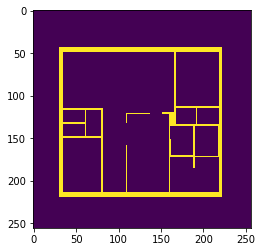

In [7]:
x=extract_wall(test)
plt.imshow(x[1])

In [8]:
#get train list
train_path='./cubicasa5k/train.txt' 
val_path='./cubicasa5k/val.txt' 
data_folder='./cubicasa5k'
data_path=['./cubicasa5k'+i for i in np.genfromtxt(train_path,dtype='str')]
def our_generator():
    for i in range(len(data_path)):
        x = extract_wall(data_path[i])[0]
        y = extract_wall(data_path[i])[1]
        yield x,y
train_dataset=tf.data.Dataset.from_generator(our_generator,output_types=(tf.float32, tf.int16))
train_df=train_dataset.batch(32).prefetch(1)
data_path=['./cubicasa5k'+i for i in np.genfromtxt(val_path,dtype='str')]
val_dataset=tf.data.Dataset.from_generator(our_generator,output_types=(tf.float32, tf.int16))
val_df=_dataset.batch(32).prefetch(1)
for i in train_df.take(5):
    print(i[1].shape)
    

(32, 256, 256)
(32, 256, 256)
(32, 256, 256)
(32, 256, 256)
(32, 256, 256)


In [9]:
type(train_df)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [211]:
#manually load
"""
X=np.empty((len(data_path),256,256,3))
Y=np.empty((len(data_path),256,256))
for i in range(len(data_path)):
    if i %100==0:
        print(i)
    X[i]=extract_wall(data_path[i])[0]
    Y[i]=extract_wall(data_path[i])[1]
"""

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
